In [4]:
import time

import numpy as np
from astropy.cosmology import FlatLambdaCDM
from multiprocessing import Process
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
import sys
sys.path.insert(1, '../coderesources')
#import fitclust2d as myfit
import priors
import fitClusParallel as myfit
import fitclust2d as fc
import emcee
import os
import TestParallelModule as tpm
from multiprocessing import Pool

zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}

cluster = 'm0416'


In [5]:
np.random.seed(42)
initial = np.random.randn(50, 23)
nwalkers, ndim = initial.shape
nsteps = 2
with Pool(initializer = tpm.setdata, initargs=([1, 2, 3, 66],)) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, tpm.original_prob, pool=pool)

    sampler.run_mcmc(initial, nsteps, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.86it/s]


In [6]:
print(tpm.data)

[1, 2, 3, 4, 5]


In [7]:
np.random.seed(42)
initial = np.random.randn(50, 23)
nwalkers, ndim = initial.shape
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, tpm.log_prob)
start = time.time()
sampler.run_mcmc(initial, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1401.92it/s]

Serial took 0.1 seconds


In [8]:
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, tpm.log_prob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initial, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 172.99it/s]

Multiprocessing took 1.9 seconds
0.0 times faster than serial


In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, tpm.log_prob)
start = time.time()
for i, result in enumerate(sampler.sample(initial, iterations = nsteps)):
    if i % 100 == 0: print("yooo")
        
end = time.time()
enserial_time = end - start
print("Serial took {0:.1f} seconds".format(enserial_time))

yooo
Serial took 0.1 seconds


In [10]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, tpm.log_prob, pool=pool)
    start = time.time()
    
    for i, result in enumerate(sampler.sample(initial, iterations = nsteps)):
        if i % 100 == 0: print("yooo")
            
    end = time.time()
    enmulti_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(enmulti_time))
    print("{0:.1f} times faster than enumerated serial".format(enserial_time / enmulti_time))
    print(sampler.get_last_sample().coords)

yooo
Multiprocessing took 2.3 seconds
0.0 times faster than enumerated serial
[[ 5.45454343e+14  4.32640293e+14  3.54423460e+14 ...  2.87835891e+15
  -1.70907557e+15  3.75219446e+14]
 [ 5.05061997e+14  4.00641088e+14  3.28094291e+14 ...  2.66536321e+15
  -1.58254191e+15  3.47422085e+14]
 [-4.53833868e+14 -3.60233482e+14 -2.94262785e+14 ... -2.39292357e+15
   1.42046944e+15 -3.12030689e+14]
 ...
 [-5.48057148e+14 -4.35019294e+14 -3.55399526e+14 ... -2.89120824e+15
   1.71622209e+15 -3.76771608e+14]
 [-2.34630555e+15 -1.85988218e+15 -1.52695907e+15 ... -1.23864038e+16
   7.35640337e+15 -1.61491080e+15]
 [ 1.55448447e+14  1.23314018e+14  1.00967224e+14 ...  8.20156422e+14
  -4.86957700e+14  1.06924817e+14]]


In [11]:
zlens = zclus[cluster]

# load the images
imgdat = fc.imgclass("Files/" + cluster + '_images_0.5.dat',zlens,cosmo)

# halo
halo = fc.haloclass()
halo.load("Files/" + cluster + "halo.dat",logflags=[True,True])

# deflection distributions (simulated separately)
losdef = fc.defclass()
losdef.load("Files/" + cluster + "_def1-los")

deffile = "Files/Deflections/m0416-sigma-defs"
memdef = fc.defclass()
memdef.load(deffile)


# lensmodel setup; remember to include the specific priors
lm = fc.lensmodel(imgdat,halo,memdef,losdef)
lm.setprior(priors.func)

# initialize the fit
fit = fc.fitclass(lm.lnP)


# set the parameters
pgal = pgals[cluster]
phalo = np.array(halo.p).flatten().tolist()
pshr = halo.pshr
pref = pgal + phalo + pshr
plabels = ['bgal', 'agal', 'alos',
 'b1', 'x1', 'y1', 'ec1', 'es1', 's1',
 'b2', 'x2', 'y2', 'ec2', 'es2', 's2',
 'b3', 'x3', 'y3', 'ec3', 'es3', 's3',
 'gc', 'gs']

    
# check one set of parameters
tmp = lm.lnP(pref)
print(tmp)
print('chisq:',-2.0*tmp['chisq'])

# optimize
fit.optimize(pref,restart=1)
print(fit.best.message)
print(fit.best.x)
print(fit.best.fun)
tmp = lm.lnP(fit.best.x)
print(tmp)
print('chisq:',-2.0*tmp['chisq'])


# run MCMC
fit.MCset(nburn = 10000, nstep = 5000)
start = time.time()
fit.MCrun()
end = time.time()
print(end - start)

# make plots
#fit.MCplot(outbase+'-mc.pdf',labels=plabels,fmt='.3f',truths=pref)

Read image data from file Files/m0416_images_0.5.dat
Read halo data from file Files/m0416halo.dat
Read deflection data from file Files/m0416_def1-los.pkl
Read deflection data from file Files/Deflections/m0416-sigma-defs.pkl
{'posterior': -96.51859929376346, 'chisq': -39.554741170861234, 'norm': -56.95051257877668, 'prior': -0.013345544125538579, 'chipri': -39.56808671498678}
chisq: 79.10948234172247
Optimize step 1 not done
[ 3.69962128e-01  1.20002195e+00  2.00000302e+00  1.34653007e+00
  1.92015690e+01 -1.49554024e+01  2.13262544e-01  5.84790466e-01
  1.02148455e+00  9.75222236e-01 -6.10652025e+00  2.68018494e+01
 -1.33325655e-01  6.07597004e-01  6.58757324e-01  7.70588251e-01
 -3.54928612e+01  3.91036675e+01 -2.53665128e-02  2.44028374e-04
  9.16552152e-01 -1.89292020e-02  3.21515131e-04]
80.2457179210645
Maximum number of function evaluations has been exceeded.
[ 3.69962128e-01  1.20002195e+00  2.00000302e+00  1.34653007e+00
  1.92015690e+01 -1.49554024e+01  2.13262544e-01  5.84790

In [12]:
zlens = zclus[cluster]

# load the images
imgdat = myfit.imgclass("Files/" + cluster + '_images_0.5.dat',zlens,cosmo)

# halo
halo = myfit.haloclass()
halo.load("Files/" + cluster + "halo.dat",logflags=[True,True])

# deflection distributions (simulated separately)
losdef = myfit.defclass()
losdef.load("Files/" + cluster + "_def1-los")

deffile = "Files/Deflections/m0416-sigma-defs"
memdef = myfit.defclass()
memdef.load(deffile)


# lensmodel setup; remember to include the specific priors
lm = myfit.lensmodel(imgdat,halo,memdef,losdef)
lm.setprior(priors.func)

# initialize the fit
fit = myfit.fitclass(lm.lnP)


# set the parameters
pgal = pgals[cluster]
phalo = np.array(halo.p).flatten().tolist()
pshr = halo.pshr
pref = pgal + phalo + pshr
plabels = ['bgal', 'agal', 'alos',
 'b1', 'x1', 'y1', 'ec1', 'es1', 's1',
 'b2', 'x2', 'y2', 'ec2', 'es2', 's2',
 'b3', 'x3', 'y3', 'ec3', 'es3', 's3',
 'gc', 'gs']

    
# check one set of parameters
tmp = lm.lnP(pref)
print(tmp)
print('chisq:',-2.0*tmp['chisq'])

# optimize
fit.optimize(pref,restart=1)
print(fit.best.message)
print(fit.best.x)
print(fit.best.fun)
tmp = lm.lnP(fit.best.x)
print(tmp)
print('chisq:',-2.0*tmp['chisq'])


# run MCMC
fit.MCset(nburn = 10000, nstep = 5000)
start = time.time()
fit.MCrun2(lm)
end = time.time()
print(end - start)

# make plots
#fit.MCplot(outbase+'-mc.pdf',labels=plabels,fmt='.3f',truths=pref)

Read image data from file Files/m0416_images_0.5.dat
Read halo data from file Files/m0416halo.dat
Read deflection data from file Files/m0416_def1-los.pkl
Read deflection data from file Files/Deflections/m0416-sigma-defs.pkl
{'posterior': -96.51859929376346, 'chisq': -39.554741170861234, 'norm': -56.95051257877668, 'prior': -0.013345544125538579, 'chipri': -39.56808671498678}
chisq: 79.10948234172247
Optimize step 1 not done
[ 3.69962128e-01  1.20002195e+00  2.00000302e+00  1.34653007e+00
  1.92015690e+01 -1.49554024e+01  2.13262544e-01  5.84790466e-01
  1.02148455e+00  9.75222236e-01 -6.10652025e+00  2.68018494e+01
 -1.33325655e-01  6.07597004e-01  6.58757324e-01  7.70588251e-01
 -3.54928612e+01  3.91036675e+01 -2.53665128e-02  2.44028374e-04
  9.16552152e-01 -1.89292020e-02  3.21515131e-04]
80.2457179210645
Maximum number of function evaluations has been exceeded.
[ 3.69962128e-01  1.20002195e+00  2.00000302e+00  1.34653007e+00
  1.92015690e+01 -1.49554024e+01  2.13262544e-01  5.84790

emcee: corner plot Files/tests/mcmc/parallel-mc.pdf


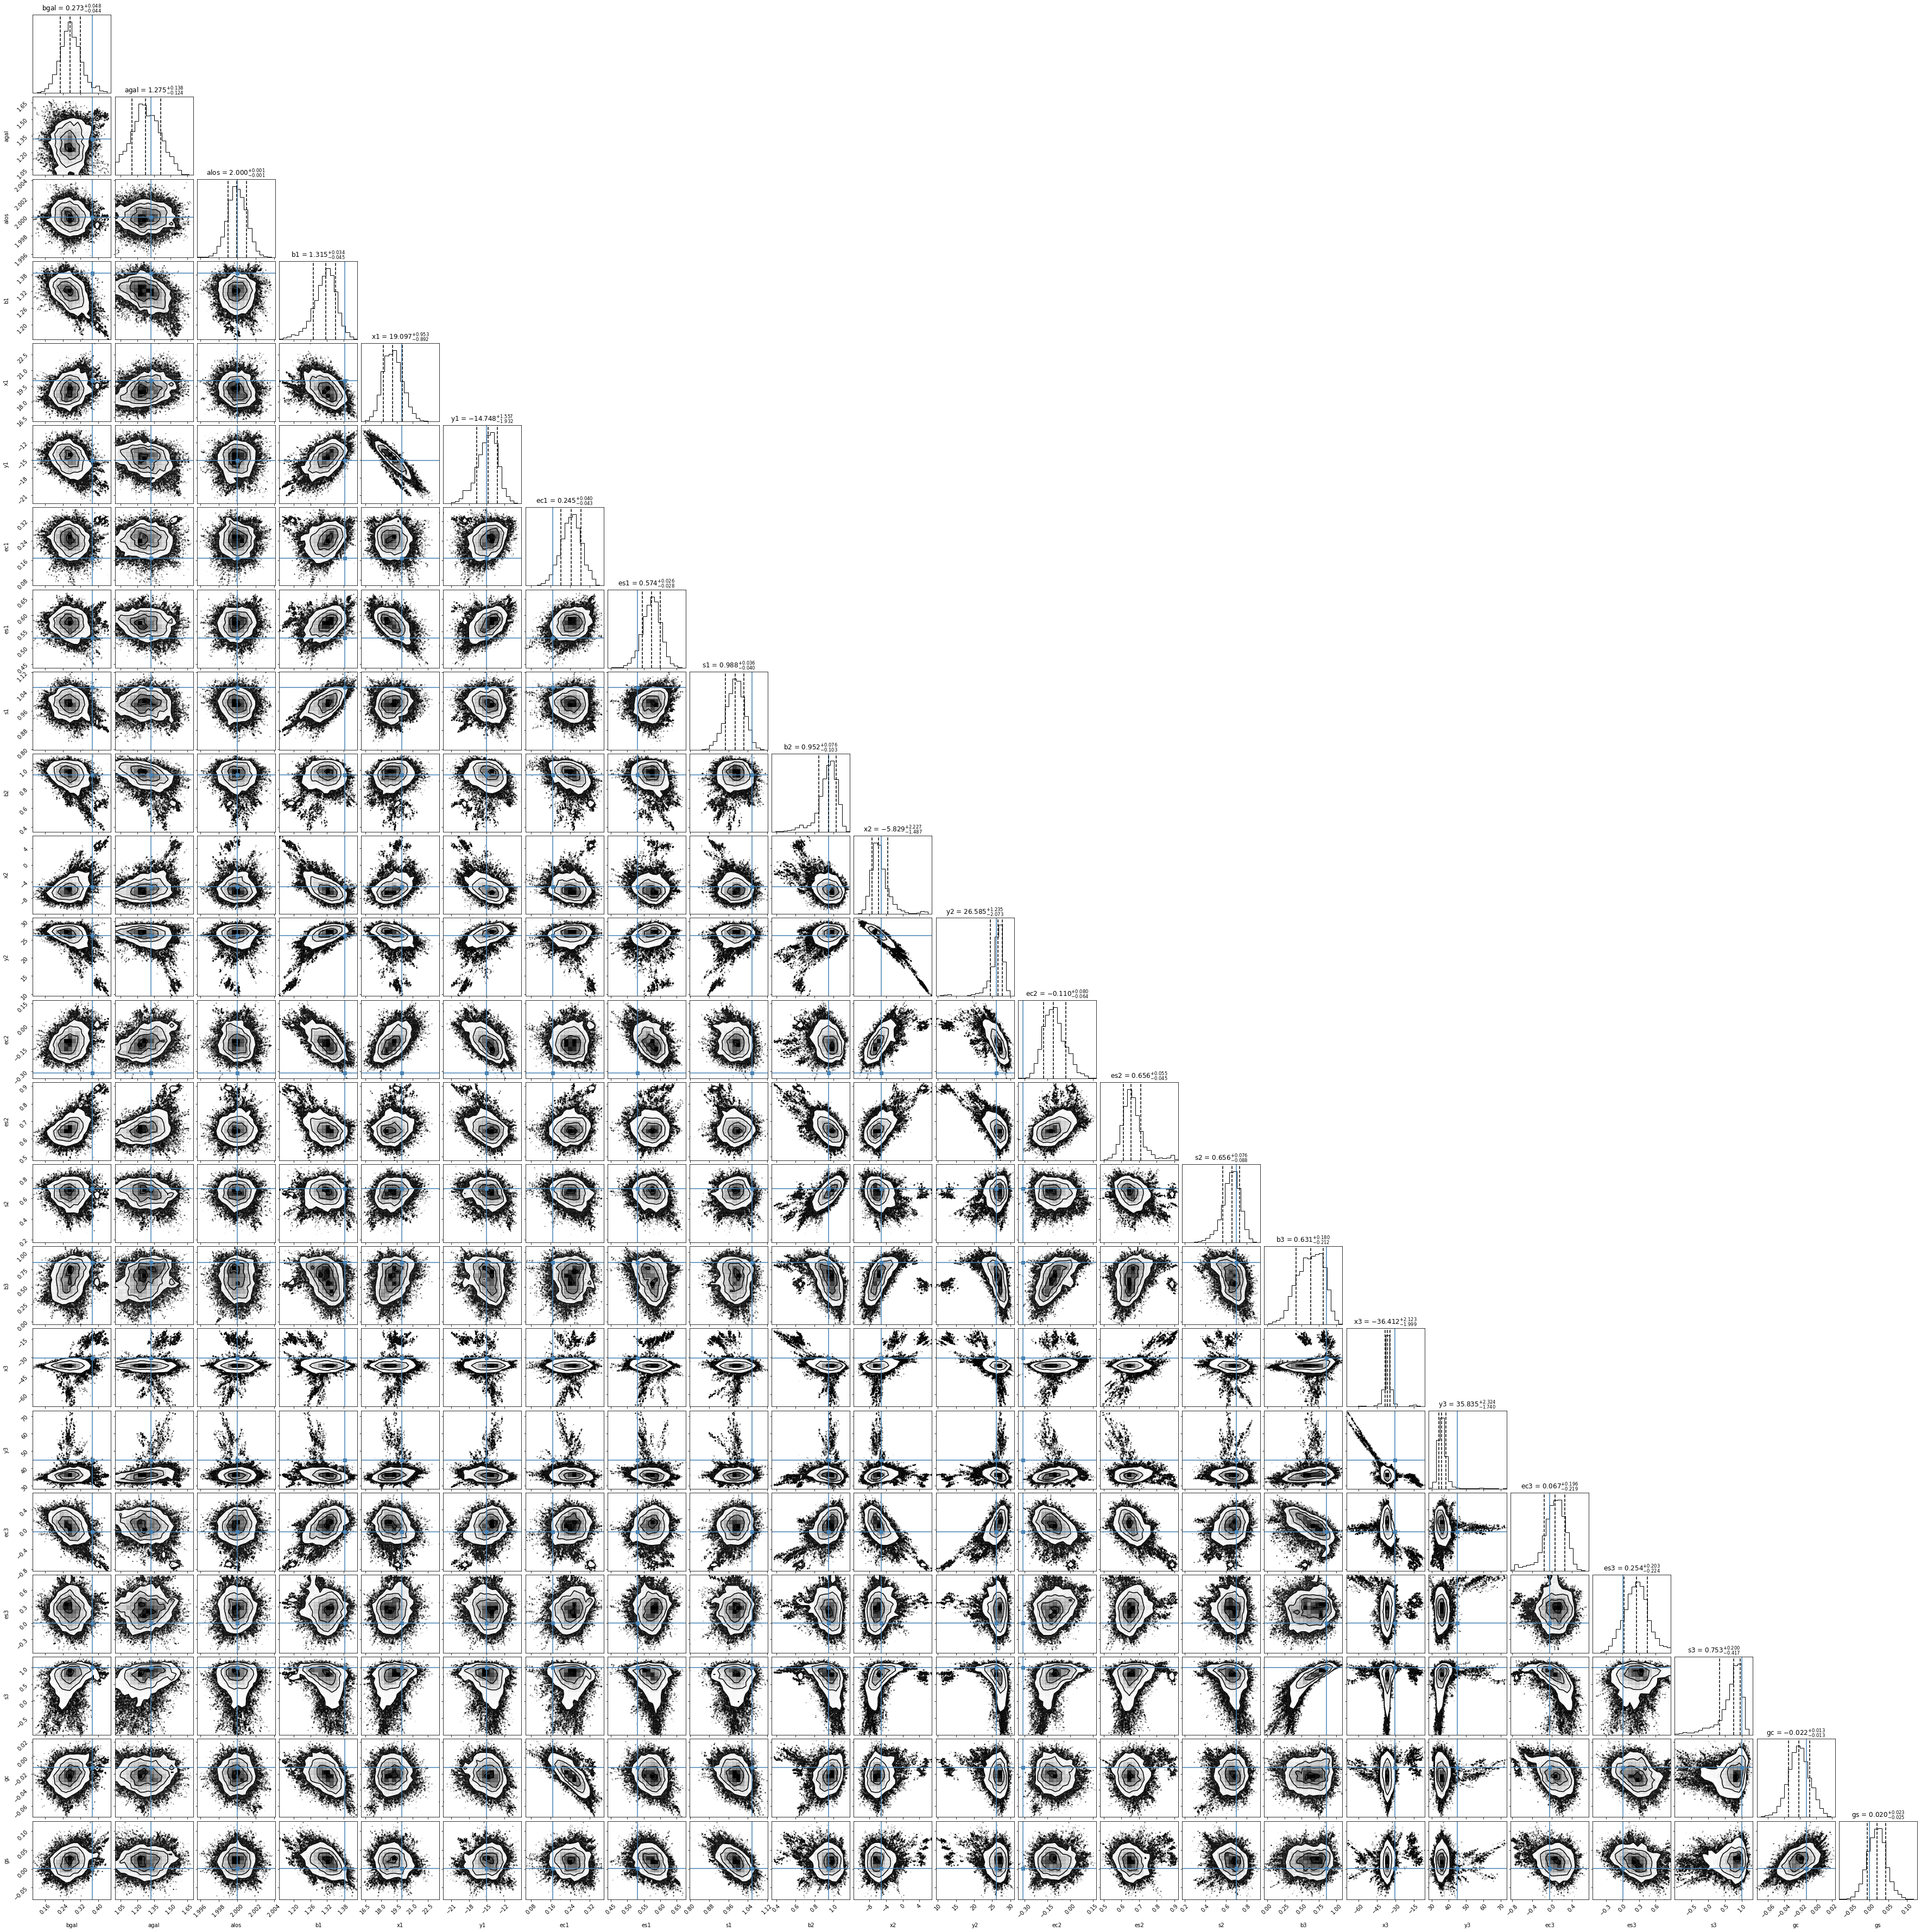

In [13]:
outbase = "Files/tests/mcmc/parallel"
fit.MCplot(outbase+'-mc.pdf',labels=plabels,fmt='.3f',truths=pref)